# Execution Time monitoring

In [1]:
# Time counting functions for Jupyter Notebook cells
# Put this in the FIRST cell and run it once
import time, atexit, pandas as pd
from IPython import get_ipython

CELL_TIMES = []
_ip = get_ipython()

def _pre(info):  # or: def _pre(*args, **kwargs):
    _ip._t0 = time.perf_counter()

def _post(result):
    dt = time.perf_counter() - getattr(_ip, "_t0", time.perf_counter())
    ih = _ip.user_ns.get("In", [])
    code = ih[-1] if ih else ""
    label = (code.strip().splitlines() or [""])[0][:80]  # first line as label
    CELL_TIMES.append({"exec_count": _ip.execution_count, "seconds": dt, "label": label})

_ip.events.register("pre_run_cell", _pre)
_ip.events.register("post_run_cell", _post)

def show_cell_times(top=None):
    df = pd.DataFrame(CELL_TIMES)
    if df.empty:
        print("No data yet."); return
    df = df.sort_values("seconds", ascending=False).reset_index(drop=True)
    if top: df = df.head(top)
    display(df)

atexit.register(show_cell_times)  # auto-show at kernel shutdown

<function __main__.show_cell_times(top=None)>

# Imports

In [2]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import pandas as pd
from datetime import datetime as DT

In [4]:
from imod import msw
from imod import mf6

In [5]:
import primod

In [6]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)
IL.reload(primod)
IL.reload(msw)
IL.reload(mf6)

<module 'imod.mf6' from 'c:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\.pixi\\envs\\default\\Lib\\site-packages\\imod\\mf6\\__init__.py'>

# Options + Basics

In [7]:
MdlN = 'NBr32'

In [8]:
U.set_verbose(False)

In [9]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax = [float(i) for i in d_INI['WINDOW'].split(',')]
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

# Load PRJ

In [10]:
PRJ_, PRJ_OBS = UIM.o_PRJ_with_OBS(Pa_PRJ)

In [11]:
PRJ, period_data = PRJ_[0], PRJ_[1]

# Load DIS and limit to Mdl Aa

In [51]:
PRJ_regrid = UIM.regrid_PRJ(PRJ, MdlN)

In [13]:
BND = PRJ_regrid['bnd']['ibound']

In [ ]:
# Set outer boundaries to -1 (for CHD)

# Get the coordinate indices for boundaries
y_coords = BND.y
x_coords = BND.x
first_y = y_coords.isel(y=0)  # First y coordinate
last_y = y_coords.isel(y=-1)  # Last y coordinate  
first_x = x_coords.isel(x=0)  # First x coordinate
last_x = x_coords.isel(x=-1)  # Last x coordinate

# Set boundary values using .loc indexing
BND.loc[:, first_y, :] = -1  # Top row (all layers, first y, all x)
BND.loc[:, last_y, :] = -1   # Bottom row (all layers, last y, all x)
BND.loc[:, :, first_x] = -1  # Left column (all layers, all y, first x)  
BND.loc[:, :, last_x] = -1   # Right column (all layers, all y, last x)

print("✅ Boundary conditions set successfully!")

✅ Boundary conditions set successfully!


In [52]:
# Set outer boundaries to -1 (for CHD)
BND.loc[:, [BND.y[0], BND.y[-1]], :] = -1  # Top and bottom rows
BND.loc[:, :, [BND.x[0], BND.x[-1]]] = -1  # Left and right columns

print("✅ Boundary conditions set successfully!")


✅ Boundary conditions set successfully!


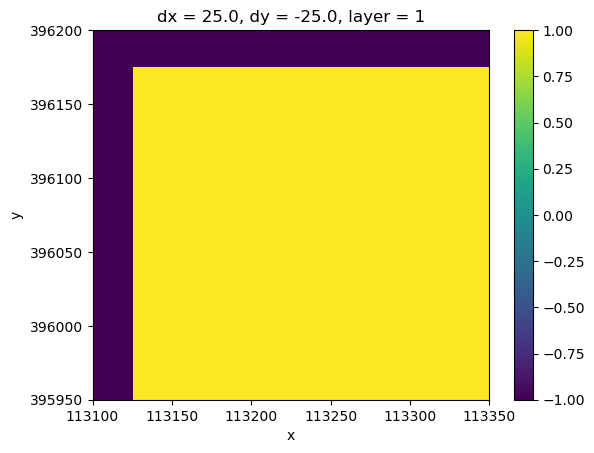

In [53]:
BND.isel(layer=0, x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

# Load MF6 Mdl

In [16]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

Using original PRJ to load MF6 Mdl gives warnings (and it's very slow). Thus, well use the regridded PRJ, which is much faster. It can be further sped up by multi-processing, but this is not implemented yet.

In [17]:
Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_regrid, period_data, times)

c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\.pixi\envs\default\Lib\site-packages\imod\util\expand_repetitions.py:89: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  well_rate["time"].iloc[-1:] = well_rate["time"].iloc[-1:].fi

In [18]:
MF6_Mdl = Sim_MF6['imported_model']

For some reason there is only 1 river system remaining. I'd expect at least 2 out of 5 (RIV and detailwatergangen) (RIV supposedly has 2, but the one that can discharge into the aquifer has a conductance of 0).

In [19]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
    
Sim_MF6["ims"] = UIM.mf6_solution_moderate_settings() # Mimic iMOD5's "Moderate" settings

# Load MSW

## 1st attempt

In [20]:
MF6_DIS = Sim_MF6["imported_model"]["dis"]  # This gets the OLD 100m grid

In [21]:
PRJ_MSW = {'cap': PRJ_regrid.copy()['cap'], 'extra': PRJ_regrid.copy()['extra']}

PRJ_regrid['cap'].keys()
for i in PRJ_regrid['cap'].keys():
    print(f" === {i} ===")
    print(PRJ_regrid['cap'][i], "\n")
x_CeCes, y_CeCes = UIM.get_CeCes_from_INI(MdlN)
PRJ['cap']['urban_area'].x.shape[0] / PRJ_regrid['cap']['urban_area'].x.shape[0]
len(x_CeCes)
PRJ['cap']['urban_area'].sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin)).plot(cmap='Spectral')
(PRJ['cap']['urban_area'].sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin)) / PRJ_regrid['cap']['urban_area']).plot(cmap='Spectral')
PRJ_regrid['cap']['urban_area'].plot(cmap='Spectral')

In [22]:
try:
    MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
    print("🎉 MetaSwap model created successfully!")
except Exception as e:
    print(f"Error creating MetaSwap model: {e}")
    MSW_Mdl = None

Error creating MetaSwap model: 
Did not find parsable path to existing .ASC file in column 2. Got
values (printing first 10): ['..\\..\\In\\CAP\\P\\NBr1\\P_20100101_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100102_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100103_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100104_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100105_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100106_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100107_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100108_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100109_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100110_NBr1.asc'].


## 2nd attempt

### Fix mete_grid.inp relative paths
MSW.MetaSwapModel.from_imod5_data is struggling with relative paths, so we'll convert them to full paths. #666 caution, if they're already full paths, this may cause an error.

In [23]:
# Replace the mete_grid.inp path in the PRJ_MSW_for_MSW dictionary
PRJ['extra']['paths'][2][0] = UIM.mete_grid_Cvt_to_AbsPa(Pa_PRJ, PRJ)

Created corrected mete_grid.inp: C:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\models\NBr\In\CAP\mete_grid\NBr5\temp\mete_grid.inp


### Finally load MSW Sim

In [24]:
# Create the MetaSwap model
MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
print("🎉 MetaSwap model loaded successfully!")

🎉 MetaSwap model loaded successfully!


# Connect MF6 to MetaSWAP

## Clip models

In [25]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [26]:
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [27]:
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [28]:
print(f"MF6 Model AoI DIS shape: {MF6_Mdl_AoI['dis'].dataset.sizes}")
print(f"MSW Model AoI grid shape: {MSW_Mdl_AoI['grid'].dataset.sizes}")
print("✅ Both models successfully clipped to Area of Interest with compatible discretization!")

MF6 Model AoI DIS shape: Frozen({'layer': 37, 'y': 344, 'x': 480})
MSW Model AoI grid shape: Frozen({'x': 480, 'y': 344, 'subunit': 2})
✅ Both models successfully clipped to Area of Interest with compatible discretization!


In [29]:
MF6_Mdl_AoI['dis'].dataset.equals(MF6_Mdl['dis'].dataset)

True

clip_box doesn't clip the packages I clipped beforehand, but it clips non raster-like packages like WEL and removes packages that are not in the AoI.

#### Sense check

In [30]:
Xmin, Xmax, Ymin, Ymax

(113100.0, 125100.0, 387600.0, 396200.0)

In [31]:
MF6_Mdl_AoI['dis']['x'].min().values, MF6_Mdl_AoI['dis']['x'].max().values, \
MF6_Mdl_AoI['dis']['y'].min().values, MF6_Mdl_AoI['dis']['y'].max().values

(array(113112.5), array(125087.5), array(387612.5), array(396187.5))

Makes sense as those are cell centers.

## Load models into memory

In [32]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

## Cleanup

### MF6 mask

In [33]:
# Create mask from current regridded model (not the old one)
mask = MF6_Mdl_AoI.domain

In [34]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

### Check if the packages are the same

In [35]:
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [36]:
# Compare the keys of both models
keys_equal = MF6_Mdl.keys() == MF6_Mdl_AoI.keys()
print(f"Are the keys identical? {keys_equal}")
print()

# Get the actual keys for detailed comparison
original_keys = set(MF6_Mdl.keys())
aoi_keys = set(MF6_Mdl_AoI.keys())

print("=== DETAILED KEY COMPARISON ===")
print(f"Original model has {len(original_keys)} packages:")
for key in sorted(original_keys):
    print(f"  - {key}")

print(f"\nAoI model has {len(aoi_keys)} packages:")
for key in sorted(aoi_keys):
    print(f"  - {key}")

# Find differences
missing_in_aoi = original_keys - aoi_keys
extra_in_aoi = aoi_keys - original_keys
common_keys = original_keys & aoi_keys

print(f"\n=== DIFFERENCES ===")
if missing_in_aoi:
    print(f"Packages REMOVED in AoI model ({len(missing_in_aoi)}):")
    for key in sorted(missing_in_aoi):
        print(f"  ❌ {key}")
        # Try to understand why it was removed
        try:
            pkg = MF6_Mdl[key]
            if hasattr(pkg, 'dataset') and hasattr(pkg.dataset, 'sizes'):
                print(f"     Size in original: {dict(pkg.dataset.sizes)}")
        except:
            pass
else:
    print("✅ No packages removed in AoI model")

if extra_in_aoi:
    print(f"\nPackages ADDED in AoI model ({len(extra_in_aoi)}):")
    for key in sorted(extra_in_aoi):
        print(f"  ➕ {key}")
else:
    print("✅ No packages added in AoI model")

print(f"\nCommon packages: {len(common_keys)}/{len(original_keys)} ({100*len(common_keys)/len(original_keys):.1f}%)")

# Show why packages might be missing
if missing_in_aoi:
    print(f"\n=== WHY PACKAGES WERE REMOVED ===")
    print("Packages are typically removed from AoI models when:")
    print("1. They have no data within the clipped boundary")
    print("2. All their stress points/cells fall outside the AoI")
    print("3. The clip_box() method filters out empty packages" \
    "")
    print("\nThis is normal behavior and indicates successful spatial filtering!")

Are the keys identical? False

=== DETAILED KEY COMPARISON ===
Original model has 165 packages:
  - chd_merged
  - dis
  - drn-1
  - drn-2
  - drn-3
  - hfb-1
  - hfb-10
  - hfb-100
  - hfb-101
  - hfb-102
  - hfb-103
  - hfb-104
  - hfb-105
  - hfb-106
  - hfb-107
  - hfb-108
  - hfb-109
  - hfb-11
  - hfb-110
  - hfb-111
  - hfb-112
  - hfb-113
  - hfb-114
  - hfb-115
  - hfb-116
  - hfb-117
  - hfb-118
  - hfb-119
  - hfb-12
  - hfb-120
  - hfb-121
  - hfb-122
  - hfb-123
  - hfb-124
  - hfb-125
  - hfb-126
  - hfb-127
  - hfb-128
  - hfb-129
  - hfb-13
  - hfb-130
  - hfb-131
  - hfb-132
  - hfb-133
  - hfb-134
  - hfb-135
  - hfb-136
  - hfb-137
  - hfb-138
  - hfb-139
  - hfb-14
  - hfb-140
  - hfb-141
  - hfb-142
  - hfb-143
  - hfb-144
  - hfb-145
  - hfb-146
  - hfb-147
  - hfb-148
  - hfb-149
  - hfb-15
  - hfb-150
  - hfb-16
  - hfb-17
  - hfb-18
  - hfb-19
  - hfb-2
  - hfb-20
  - hfb-21
  - hfb-22
  - hfb-23
  - hfb-24
  - hfb-25
  - hfb-26
  - hfb-27
  - hfb-28
  - hfb-29

In [37]:
# Analyze the data content of common packages
print("=== PACKAGE DATA COMPARISON ===")
print("Comparing spatial dimensions and data ranges for common packages:\n")

for key in sorted(common_keys):
    print(f"📦 {key}:")
    try:
        orig_pkg = MF6_Mdl[key] 
        aoi_pkg = MF6_Mdl_AoI[key]
        
        # Compare dataset sizes
        if hasattr(orig_pkg, 'dataset') and hasattr(aoi_pkg, 'dataset'):
            orig_sizes = dict(orig_pkg.dataset.sizes)
            aoi_sizes = dict(aoi_pkg.dataset.sizes)
            
            print(f"   Original sizes: {orig_sizes}")
            print(f"   AoI sizes:      {aoi_sizes}")
            
            # Calculate reduction ratios
            for dim in ['x', 'y']:
                if dim in orig_sizes and dim in aoi_sizes:
                    reduction = aoi_sizes[dim] / orig_sizes[dim]
                    print(f"   {dim} reduction: {reduction:.3f} ({aoi_sizes[dim]}/{orig_sizes[dim]} cells)")
            
            # Check if data values are the same (for first few values)
            if hasattr(orig_pkg.dataset, 'data_vars') and hasattr(aoi_pkg.dataset, 'data_vars'):
                common_vars = set(orig_pkg.dataset.data_vars) & set(aoi_pkg.dataset.data_vars)
                if common_vars:
                    var = list(common_vars)[0]  # Check first variable
                    orig_data = orig_pkg.dataset[var]
                    aoi_data = aoi_pkg.dataset[var]
                    
                    # Check if AoI data is a subset of original
                    if 'x' in orig_data.dims and 'y' in orig_data.dims:
                        print(f"   Variable '{var}': Data appears to be spatially clipped ✓")
                    else:
                        print(f"   Variable '{var}': Non-spatial data")
        else:
            print("   No dataset attributes to compare")
            
    except Exception as e:
        print(f"   ⚠️  Error comparing {key}: {e}")
    
    print()  # Empty line for readability

=== PACKAGE DATA COMPARISON ===
Comparing spatial dimensions and data ranges for common packages:

📦 chd_merged:
   Original sizes: {'time': 1, 'layer': 19, 'y': 344, 'x': 480}
   AoI sizes:      {'layer': 19, 'y': 344, 'x': 480, 'time': 1}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'print_input': Non-spatial data

📦 dis:
   Original sizes: {'layer': 37, 'y': 344, 'x': 480}
   AoI sizes:      {'layer': 37, 'y': 344, 'x': 480}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'top': Data appears to be spatially clipped ✓

📦 drn-1:
   Original sizes: {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   AoI sizes:      {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'print_input': Non-spatial data

📦 drn-2:
   Original sizes: {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   AoI sizes:      {'layer': 1, 'y': 344, 'x': 480, 'time': 1}

In [38]:
# Compare coordinate bounds to verify clipping worked correctly
print("=== COORDINATE BOUNDS COMPARISON ===")
print(f"Target clipping bounds: X({Xmin:.1f}, {Xmax:.1f}), Y({Ymin:.1f}, {Ymax:.1f})")
print()

# Check DIS package bounds (most reliable for spatial extent)
if 'dis' in common_keys:
    try:
        orig_dis = MF6_Mdl['dis']
        aoi_dis = MF6_Mdl_AoI['dis']
        
        # Original bounds
        orig_x_min, orig_x_max = float(orig_dis.dataset.x.min()), float(orig_dis.dataset.x.max())
        orig_y_min, orig_y_max = float(orig_dis.dataset.y.min()), float(orig_dis.dataset.y.max())
        
        # AoI bounds  
        aoi_x_min, aoi_x_max = float(aoi_dis.dataset.x.min()), float(aoi_dis.dataset.x.max())
        aoi_y_min, aoi_y_max = float(aoi_dis.dataset.y.min()), float(aoi_dis.dataset.y.max())
        
        print("Original model bounds:")
        print(f"   X: {orig_x_min:.1f} to {orig_x_max:.1f} (range: {orig_x_max-orig_x_min:.1f})")
        print(f"   Y: {orig_y_min:.1f} to {orig_y_max:.1f} (range: {orig_y_max-orig_y_min:.1f})")
        
        print("\nAoI model bounds:")
        print(f"   X: {aoi_x_min:.1f} to {aoi_x_max:.1f} (range: {aoi_x_max-aoi_x_min:.1f})")
        print(f"   Y: {aoi_y_min:.1f} to {aoi_y_max:.1f} (range: {aoi_y_max-aoi_y_min:.1f})")
        
        # Verify clipping worked as expected
        x_within_bounds = (aoi_x_min >= Xmin-dx) and (aoi_x_max <= Xmax+dx)
        y_within_bounds = (aoi_y_min >= Ymin-dy) and (aoi_y_max <= Ymax+dy)
        
        print(f"\nClipping verification:")
        print(f"   X bounds within target: {'✓' if x_within_bounds else '✗'}")
        print(f"   Y bounds within target: {'✓' if y_within_bounds else '✗'}")
        
        if x_within_bounds and y_within_bounds:
            print("   🎉 Clipping successful!")
        else:
            print("   ⚠️  Clipping may not have worked as expected")
            
        # Calculate area reduction
        orig_area = (orig_x_max - orig_x_min) * (orig_y_max - orig_y_min)
        aoi_area = (aoi_x_max - aoi_x_min) * (aoi_y_max - aoi_y_min)
        area_ratio = aoi_area / orig_area
        
        print(f"\nArea reduction:")
        print(f"   Original area: {orig_area:,.0f} m²")
        print(f"   AoI area: {aoi_area:,.0f} m²") 
        print(f"   Ratio: {area_ratio:.4f} ({area_ratio*100:.2f}%)")
        
    except Exception as e:
        print(f"Error comparing DIS bounds: {e}")
else:
    print("DIS package not found in common keys - cannot compare bounds")

=== COORDINATE BOUNDS COMPARISON ===
Target clipping bounds: X(113100.0, 125100.0), Y(387600.0, 396200.0)

Original model bounds:
   X: 113112.5 to 125087.5 (range: 11975.0)
   Y: 387612.5 to 396187.5 (range: 8575.0)

AoI model bounds:
   X: 113112.5 to 125087.5 (range: 11975.0)
   Y: 387612.5 to 396187.5 (range: 8575.0)

Clipping verification:
   X bounds within target: ✓
   Y bounds within target: ✓
   🎉 Clipping successful!

Area reduction:
   Original area: 102,685,625 m²
   AoI area: 102,685,625 m²
   Ratio: 1.0000 (100.00%)


In [39]:
# Print the names of common packages
print("=== COMMON PACKAGES ===")
print(f"These {len(common_keys)} packages are present in both models:")
for i, key in enumerate(sorted(common_keys), 1):
    print(f"{i:2d}. {key}")

=== COMMON PACKAGES ===
These 14 packages are present in both models:
 1. chd_merged
 2. dis
 3. drn-1
 4. drn-2
 5. drn-3
 6. ic
 7. msw-rch
 8. msw-sprinkling
 9. npf
10. oc
11. riv-1riv
12. sto
13. wel-WEL_Br_Wa_T_
14. wel-WEL_Ind_Br_T


In [40]:
MF6_Mdl_AoI.keys()

KeysView(GroundwaterFlowModel(
    listing_file=None,
    print_input=False,
    print_flows=False,
    save_flows=False,
    newton=False,
    under_relaxation=False,
){
    'dis': StructuredDiscretization,
    'npf': NodePropertyFlow,
    'sto': StorageCoefficient,
    'ic': InitialConditions,
    'wel-WEL_Ind_Br_T': Well,
    'wel-WEL_Br_Wa_T_': Well,
    'msw-sprinkling': LayeredWell,
    'msw-rch': Recharge,
    'drn-1': Drainage,
    'drn-2': Drainage,
    'drn-3': Drainage,
    'riv-1riv': River,
    'chd_merged': ConstantHead,
    'oc': OutputControl,
})

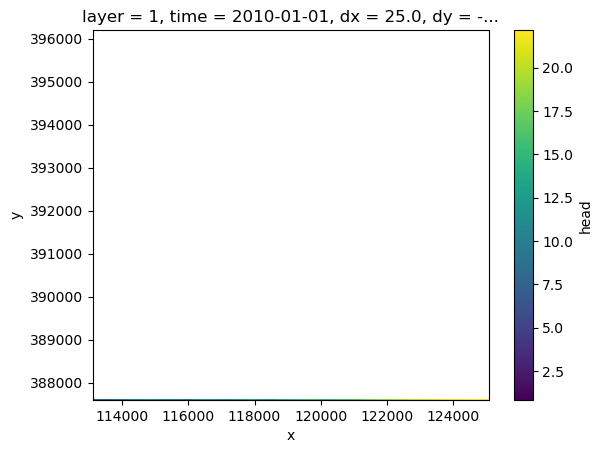

In [42]:
MF6_Mdl_AoI['chd_merged']['head'].isel(time=0, layer=0).plot.imshow(cmap='viridis')

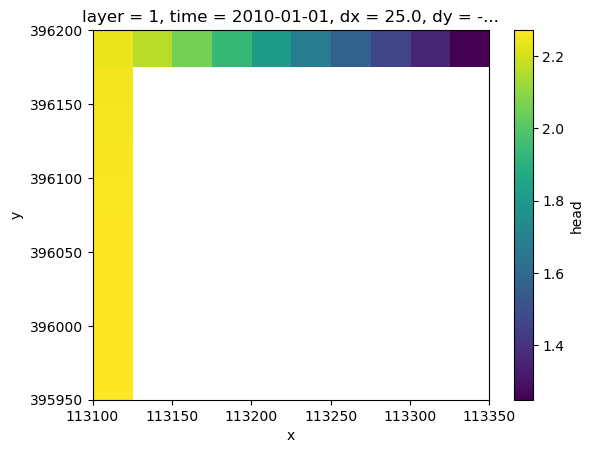

In [98]:
MF6_Mdl_AoI['chd_merged']['head'].isel(time=0, layer=0, x=range(10), y=range(10)).plot.imshow(cmap='viridis')

Seems like CHD has finally been applied correctly!

This is ok. The only missing package is one of the WEL packages, which has no items in the model area.

### Cleanup MF6

In [43]:
try:
    for Pkg in [i for i in MF6_Mdl_AoI.keys() if ('riv' in i.lower()) or ('drn' in i.lower())]:
        MF6_Mdl_AoI[Pkg].cleanup(DIS_AoI)
except:
    print('Failed to cleanup packaes. Proceeding without cleanup. Fingers crossed!')

### MSW

In [44]:
# Cleanup MetaSWAP
MSW_Mdl_AoI["grid"].dataset["rootzone_depth"] = MSW_Mdl_AoI["grid"].dataset["rootzone_depth"].fillna(1.0)

## Couple

In [45]:
metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(MSW_Mdl_AoI, Sim_MF6_AoI, coupling_list=[metamod_coupling])

In [46]:
os.makedirs(d_Pa['Pa_MdlN'], exist_ok=True) # Create simulation directory if it doesn't exist

In [47]:
# Those can be changed to relative paths.
Pa_MF6_DLL = r"C:\OD\WS_Mdl\software\iMOD5\bin\iMOD_coupler\libmf6.dll"
Pa_MSW_DLL = r"C:\OD\WS_Mdl\software\iMOD5\bin\iMOD_coupler\MetaSWAP.dll"

In [48]:
metamod.write(directory=d_Pa['Pa_MdlN'], modflow6_dll=Pa_MF6_DLL, metaswap_dll=Pa_MSW_DLL, metaswap_dll_dependency=PDN(Pa_MF6_DLL))

# Review execution times per cell

In [49]:
t = show_cell_times()

,exec_count,seconds,label
0,11,104.908572,"PRJ_, PRJ_OBS = UIM.o_PRJ_with_OBS(Pa_PRJ)"
1,18,76.217058,Sim_MF6 = mf6.Modflow6Simulation.from_imod5_da...
2,3,17.839257,import WS_Mdl.utils as U
3,49,17.314050,"metamod.write(directory=d_Pa['Pa_MdlN'], modfl..."
4,26,9.886252,"Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_m..."
5,23,4.721034,try:
6,33,4.695698,for pkg in MF6_Mdl_AoI.values():
7,25,4.511119,# Create the MetaSwap model
8,16,1.585314,"BND.isel(layer=0, x=range(0,10), y=range(0,10)..."
9,6,0.678509,import primod


# Execute model

In [50]:
# Execute the coupled model
print("🚀 Starting coupled model execution...")
print(f"Model directory: {d_Pa['Pa_MdlN']}")

# Check what files were written
print("\n📁 Checking written model files:")
if PE(d_Pa['Pa_MdlN']):
    model_files = LD(d_Pa['Pa_MdlN'])
    for file in sorted(model_files):
        print(f"  - {file}")
    
    # Look for the main execution file (usually .toml or similar)
    toml_files = [f for f in model_files if f.endswith('.toml')]
    if toml_files:
        print(f"\n🎯 Found TOML configuration file: {toml_files[0]}")
        main_toml = PJ(d_Pa['Pa_MdlN'], toml_files[0])
        
        # Since we have the DLL paths, we can try to execute using the iMOD coupler
        # The iMOD coupler typically needs the .toml file as input
        coupler_exe = PJ(PDN(Pa_MF6_DLL), "imodc.exe")
        
        if PE(coupler_exe):
            print(f"✅ Found iMOD coupler: {coupler_exe}")
            print(f"🔄 Executing: {coupler_exe} {main_toml}")
            
            # Execute the model (this will take some time)
            import subprocess
            try:
                result = subprocess.run([coupler_exe, main_toml], 
                                      cwd=d_Pa['Pa_MdlN'], 
                                      capture_output=True, 
                                      text=True,
                                      timeout=3600)  # 1 hour timeout
                
                print(f"Return code: {result.returncode}")
                if result.stdout:
                    print("STDOUT:")
                    print(result.stdout)
                if result.stderr:
                    print("STDERR:")
                    print(result.stderr)
                    
                if result.returncode == 0:
                    print("✅ Model execution completed successfully!")
                else:
                    print(f"❌ Model execution failed with return code {result.returncode}")
                    
            except subprocess.TimeoutExpired:
                print("⏰ Model execution timed out after 1 hour")
            except Exception as e:
                print(f"❌ Error executing model: {e}")
        else:
            print(f"❌ iMOD coupler not found at: {coupler_exe}")
            print("You may need to execute the model manually using the iMOD coupler")
    else:
        print("❌ No TOML configuration file found")
else:
    print(f"❌ Model directory not found: {d_Pa['Pa_MdlN']}")
    

🚀 Starting coupled model execution...
Model directory: C:/OD/WS_Mdl\models/NBr\Sim/NBr32

📁 Checking written model files:
  - exchanges
  - imod_coupler.toml
  - metaswap
  - modflow6

🎯 Found TOML configuration file: imod_coupler.toml
✅ Found iMOD coupler: C:\OD\WS_Mdl\software\iMOD5\bin\iMOD_coupler\imodc.exe
🔄 Executing: C:\OD\WS_Mdl\software\iMOD5\bin\iMOD_coupler\imodc.exe C:/OD/WS_Mdl\models/NBr\Sim/NBr32\imod_coupler.toml
Return code: 1
STDERR:
iMOD Coupler: iMOD Coupler 0.11.0-dev
iMOD Coupler: iMOD Coupler run failed with: 
Traceback (most recent call last):

  File "imod_coupler\__main__.py", line 57, in <module>

> File "imod_coupler\__main__.py", line 26, in main

  File "imod_coupler\__main__.py", line 45, in run_coupler

  File "imod_coupler\drivers\driver.py", line 70, in get_driver

  File "imod_coupler\drivers\metamod\config.py", line 89, in __init__

  File "pydantic\main.py", line 341, in pydantic.main.BaseModel.__init__

pydantic.error_wrappers.ValidationError: 1 va